In [1]:
import os, shutil, json
from sklearn.model_selection import train_test_split

# 1. Rename and copy raw image to nnUNet_raw folder

Train: 53 patients, Test: 22 patients

In [2]:
raw_dir = "/media/storage/luu/BrainMRIReview/raw/MSLesSeg/train"
nnUNet_raw = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg"
nnUNet_raw_imagesTr = os.path.join(nnUNet_raw, "imagesTr")
nnUNet_raw_labelsTr = os.path.join(nnUNet_raw, "labelsTr")
nnUNet_raw_imagesTs = os.path.join(nnUNet_raw, "imagesTs")
nnUNet_raw_labelsTs = os.path.join(nnUNet_raw, "labelsTs")

In [3]:
patients = os.listdir(raw_dir)
train_patients, test_patients = train_test_split(patients, test_size=0.1, random_state=42)
n_train = len(train_patients)
n_test = len(test_patients)

print(f"{n_train} training patients, {n_test} testing patients.")
print(f"Testing patients: {test_patients}")

47 training patients, 6 testing patients.
Testing patients: ['P26', 'P47', 'P52', 'P2', 'P49', 'P13']


In [ ]:
channel_name_to_modality = {
    "1": "T1",
    "2": "T2",
    "3": "FLAIR"
}
modality_to_channel_name = {
    "T1": "1",
    "T2": "2",
    "FLAIR": "3"
}

def get_path_dict(patients, patient_dir, output_images_dir, output_labels_dir=None):
    path_dict = {}

    for patient in patients:
        path_dict[patient] = []
        patient_path = os.path.join(patient_dir, patient)
        timepoints = os.listdir(patient_path)
        for timepoint in timepoints:
            tp_path = os.path.join(patient_path, timepoint)
            images = os.listdir(tp_path)
            for image in images:
                # Create nnUNet_raw path
                image_id = image.replace(".nii.gz", "") # P26_T1_T1
                modality = image_id.split("_")[-1] # T1
                session_id = "_".join(image_id.split("_")[:-1]) # P26_T1

                if modality == "MASK":
                    new_image_id = session_id
                    if output_labels_dir is None:
                        raise ValueError("Missing dir for saving labels.")
                    new_image_path = os.path.join(output_labels_dir, f"{new_image_id}.nii.gz")
                else:
                    channel = modality_to_channel_name[modality]
                    new_image_id = f"{session_id}_000{channel}"
                    new_image_path = os.path.join(output_images_dir, f"{new_image_id}.nii.gz")
                
                # Original path
                original_image_path = os.path.join(tp_path, image)
                
                # Save a pair of original image path and nnUNet_raw image path
                path_dict[patient].append((original_image_path, new_image_path))
    
    return path_dict

# Copy training data
def save_path_dict_for_train():
    path_dict = get_path_dict(
        patients=train_patients,
        patient_dir=raw_dir,
        output_images_dir=nnUNet_raw_imagesTr,
        output_labels_dir=nnUNet_raw_labelsTr
    )

    output_path = os.path.join(nnUNet_raw, "path_dict_train.json")
    with open(output_path, "w") as f:
        json.dump(path_dict, f, indent=4)

    return path_dict

def save_path_dict_for_test():
    path_dict = get_path_dict(
        patients=test_patients,
        patient_dir=raw_dir,
        output_images_dir=nnUNet_raw_imagesTs,
        output_labels_dir=nnUNet_raw_labelsTs
    )

    output_path = os.path.join(nnUNet_raw, "path_dict_test.json")
    with open(output_path, "w") as f:
        json.dump(path_dict, f, indent=4)
        
    return path_dict

# Copy from original path to nnUNet_path
def copy_files(path_dict):
    
    current_patient = 0
    total_patient = len(path_dict)

    for patient, paths in path_dict.items():
        current_patient += 1
        print(f"[{current_patient}/{total_patient}] Copying patient {patient}...")
        
        for src, dst in paths:
            #print(src, dst)
            shutil.copyfile(src=src, dst=dst)


In [ ]:
# train_path_dict = save_path_dict_for_train()
# test_path_dict = save_path_dict_for_test()

# copy_files(train_path_dict)
# copy_files(test_path_dict)

# 2. Visualize prediction

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [4]:
prediction_dir = "/media/storage/luu/SmallLesionMRI/MSLesSeg/SegResNet"
gt_images_dir = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg/imagesTs"
gt_labels_dir = "/media/storage/luu/nnUNet_raw/Dataset333_MSLesSeg/labelsTs"
metrics_csv = "metrics/metrics_MSLesSeg_SegResNet.csv"

In [5]:
df = pd.read_csv(metrics_csv)
df

,sample,DICE,Hausdorff,Sensitivity,Specificity,True_volume,Predicted_volume
0,P13_T1.nii.gz,0.761415,9.643651,0.696187,0.999822,9.677,8.019
1,P13_T2.nii.gz,0.824014,3.162278,0.818757,0.999760,10.268,10.137
2,P26_T1.nii.gz,0.813891,3.000000,0.751920,0.999912,6.639,5.628
3,P2_T1.nii.gz,0.819036,8.062258,0.886776,0.999913,2.261,2.635
4,P2_T2.nii.gz,0.772386,23.853721,0.750761,0.999912,3.286,3.102
5,P2_T3.nii.gz,0.790535,8.246211,0.859703,0.999885,2.623,3.082
6,P2_T4.nii.gz,0.800187,13.304135,0.872449,0.999874,2.940,3.471
7,P47_T1.nii.gz,0.849946,1.414214,0.887916,0.999476,18.736,20.410
8,P49_T1.nii.gz,0.847711,4.690416,0.759054,0.999847,34.709,27.449
9,P49_T2.nii.gz,0.225341,56.293872,0.458199,0.997193,7.763,23.807


In [6]:
mean_dice = df["DICE"].mean()
mean_hd   = df["Hausdorff"].mean()
mean_sen  = df["Sensitivity"].mean()
mean_spe  = df["Specificity"].mean()

print(f"Mean Dice={mean_dice:.4f}\nMean HD={mean_hd:.4f}\nMean Sensitivity={mean_sen:.4f}\nMean Specificity={mean_spe:.4f}")

Mean Dice=0.7524
Mean HD=15.2431
Mean Sensitivity=0.7750
Mean Specificity=0.9996


In [7]:
sorted_df = df.sort_values(by="DICE", ascending=False)
sorted_df

,sample,DICE,Hausdorff,Sensitivity,Specificity,True_volume,Predicted_volume
7,P47_T1.nii.gz,0.849946,1.414214,0.887916,0.999476,18.736,20.410
8,P49_T1.nii.gz,0.847711,4.690416,0.759054,0.999847,34.709,27.449
1,P13_T2.nii.gz,0.824014,3.162278,0.818757,0.999760,10.268,10.137
3,P2_T1.nii.gz,0.819036,8.062258,0.886776,0.999913,2.261,2.635
2,P26_T1.nii.gz,0.813891,3.000000,0.751920,0.999912,6.639,5.628
6,P2_T4.nii.gz,0.800187,13.304135,0.872449,0.999874,2.940,3.471
10,P52_T1.nii.gz,0.797615,2.236068,0.789171,0.999913,3.306,3.236
5,P2_T3.nii.gz,0.790535,8.246211,0.859703,0.999885,2.623,3.082
4,P2_T2.nii.gz,0.772386,23.853721,0.750761,0.999912,3.286,3.102
0,P13_T1.nii.gz,0.761415,9.643651,0.696187,0.999822,9.677,8.019


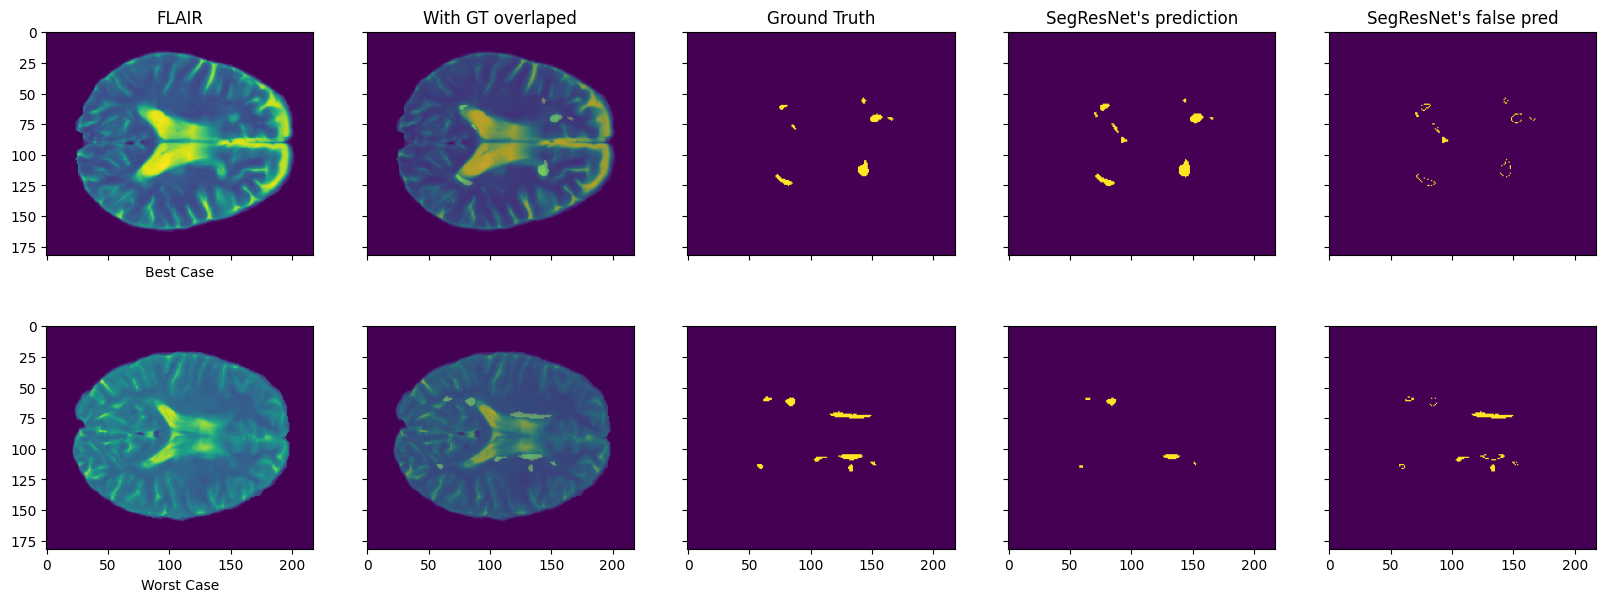

In [96]:
# Visualize best and worst case
slice_idx = 90
fig, axs = plt.subplots(2, 5, figsize=(20, 7), sharex=True, sharey=True)

# Set titles
axs[0,0].set_title("FLAIR")
axs[0,1].set_title("With GT overlaped")
axs[0,2].set_title("Ground Truth")
axs[0,3].set_title("SegResNet's prediction")
axs[0,4].set_title("SegResNet's false pred")

axs[0,0].set_xlabel("Best Case")
axs[1,0].set_xlabel("Worst Case")


# # Show best case
best_fn = sorted_df.iloc[0,0]
best_id = best_fn.replace(".nii.gz", "")
best_img = nib.load(os.path.join(gt_images_dir, f"{best_id}_0002.nii.gz")).get_fdata()
best_gt = nib.load(os.path.join(gt_labels_dir, best_fn)).get_fdata()
best_pred = nib.load(os.path.join(prediction_dir, best_fn)).get_fdata()
best_missed = np.abs(best_gt - best_pred)

axs[0,0].imshow(best_img[...,slice_idx])
axs[0,1].imshow(best_img[...,slice_idx])
axs[0,1].imshow(best_gt[...,slice_idx], alpha=0.3)
axs[0,2].imshow(best_gt[...,slice_idx])
axs[0,3].imshow(best_pred[..., slice_idx])
axs[0,4].imshow(best_missed[..., slice_idx])



# Show worst case
worst_fn = sorted_df.iloc[-1,0]
worst_id = worst_fn.replace(".nii.gz", "")
worst_img = nib.load(os.path.join(gt_images_dir, f"{worst_id}_0002.nii.gz")).get_fdata()
worst_gt = nib.load(os.path.join(gt_labels_dir, worst_fn)).get_fdata()
worst_pred = nib.load(os.path.join(prediction_dir, worst_fn)).get_fdata()
worst_missed = np.abs(worst_gt - worst_pred)

axs[1,0].imshow(worst_img[...,slice_idx])
axs[1,1].imshow(worst_img[...,slice_idx])
axs[1,1].imshow(worst_gt[...,slice_idx], alpha=0.3)
axs[1,2].imshow(worst_gt[...,slice_idx])
axs[1,3].imshow(worst_pred[..., slice_idx])
#axs[1,4].imshow(worst_pred[..., slice_idx])
axs[1,4].imshow(worst_missed[..., slice_idx])


# Notes:
1. What is the small lesions? (how much cm?) (*)
2. Compare predictions over timepoints of the same patient
3. Task: Identiy small lesions, classify small tumors, evaluate the size/volumne of the lesion
4. Dataset: MS, metastasis, maybe stroke.

In [87]:
# Visualize predictions of a patient with multiple timepoints
def plot_prediction_timepoints(patient_id, n_timepoints):
    slice_idx = 90
    fig, axs = plt.subplots(n_timepoints, 5, figsize=(20, n_timepoints*3), sharex=True, sharey=True)

    # Set titles
    axs[0,0].set_title("FLAIR")
    axs[0,1].set_title("With GT overlaped")
    axs[0,2].set_title("Ground Truth")
    axs[0,3].set_title("SegResNet's prediction")
    axs[0,4].set_title("SegResNet's false pred")

    # Set xlabels
    for j in range(n_timepoints):
        axs[j,0].set_xlabel(f"Timepoint {j+1}")


    for i in range(n_timepoints):
        sample_id = f"{patient_id}_T{i+1}"
        sample_fn = f"{sample_id}_0002.nii.gz"
        sample_img = nib.load(os.path.join(gt_images_dir, sample_fn)).get_fdata()
        sample_gt = nib.load(os.path.join(gt_labels_dir, f"{sample_id}.nii.gz")).get_fdata()
        sample_pred = nib.load(os.path.join(prediction_dir, f"{sample_id}.nii.gz")).get_fdata()
        sample_missed = np.abs(sample_gt - sample_pred)


        axs[i,0].imshow(best_img[...,slice_idx])
        axs[i,1].imshow(best_img[...,slice_idx])
        axs[i,1].imshow(best_gt[...,slice_idx], alpha=0.3)
        axs[i,2].imshow(best_gt[...,slice_idx])
        axs[i,3].imshow(best_pred[..., slice_idx])
        axs[i,4].imshow(best_missed[..., slice_idx])


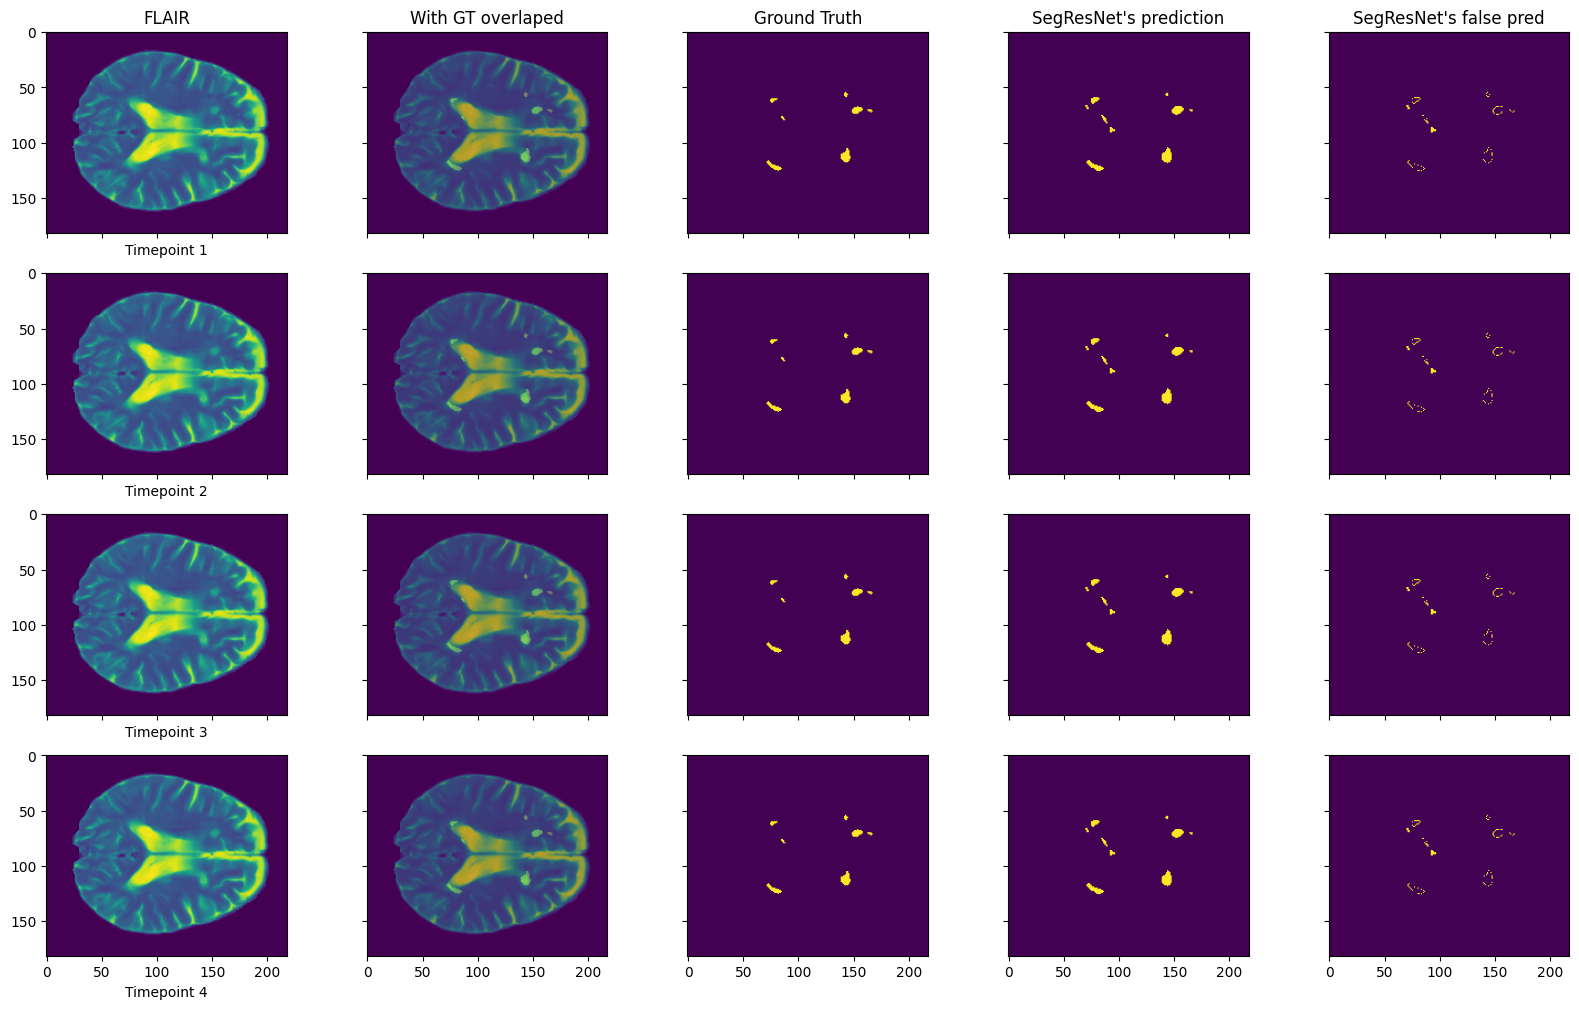

In [88]:
plot_prediction_timepoints(patient_id="P2", n_timepoints=4)

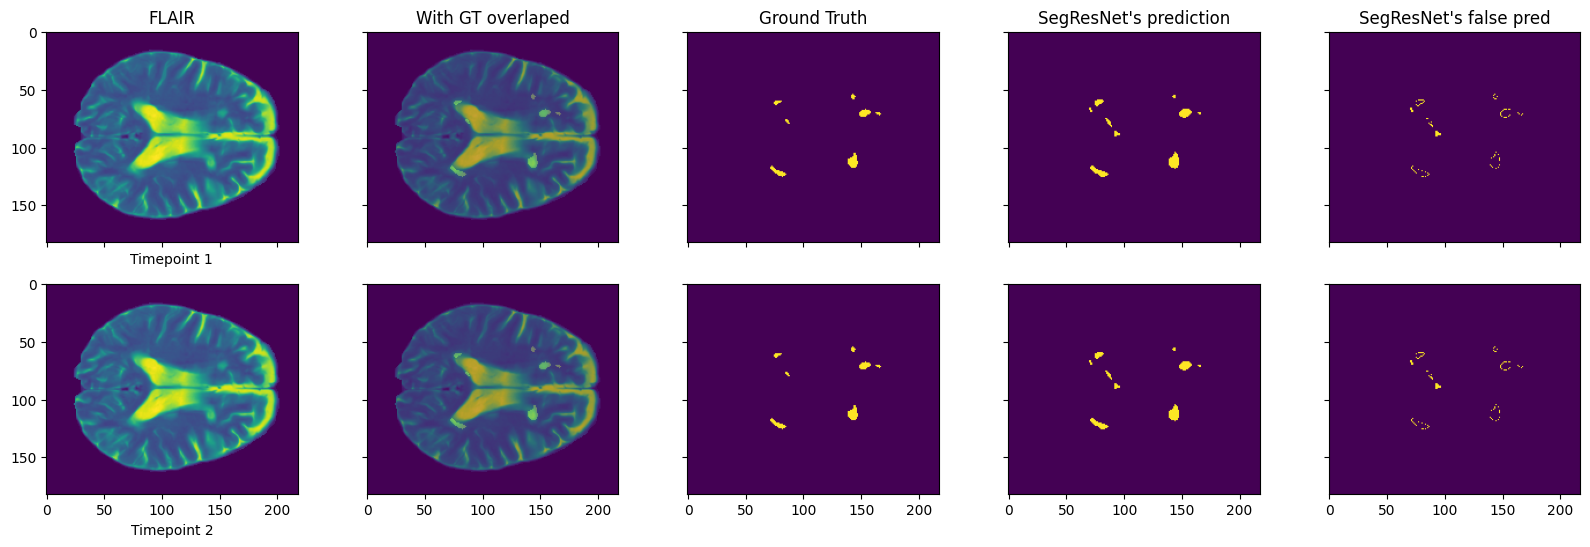

In [89]:
plot_prediction_timepoints(patient_id="P52", n_timepoints=2)

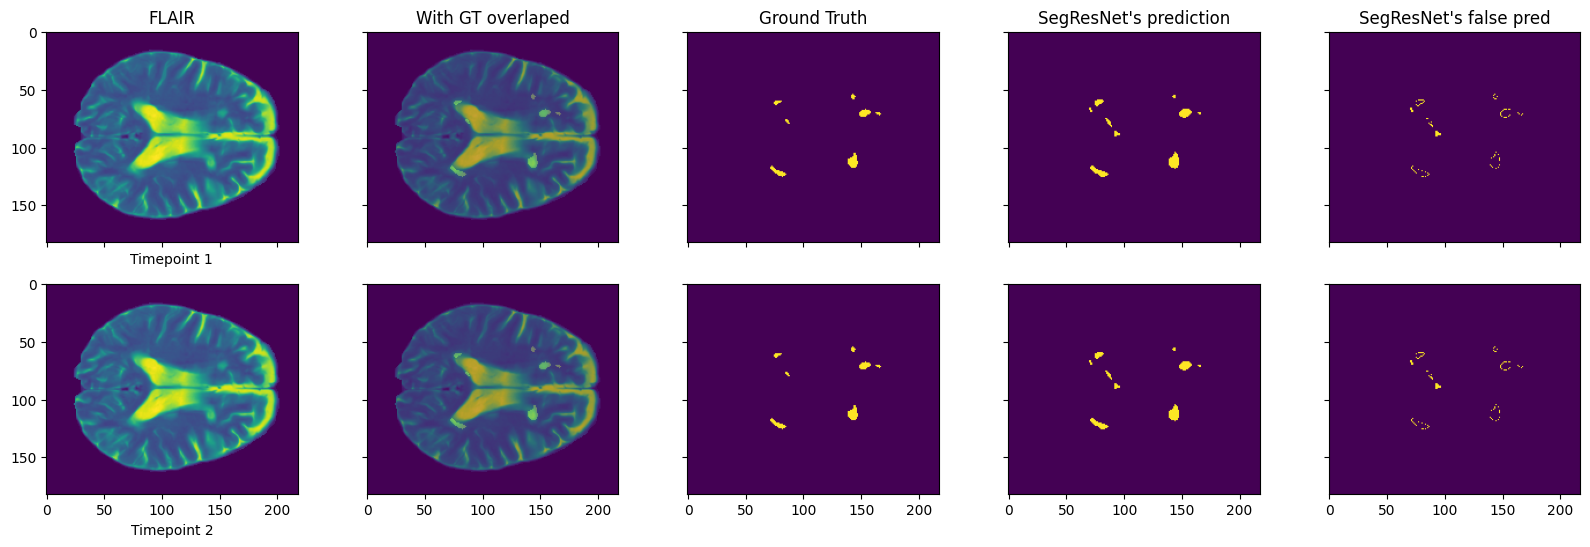

In [90]:
plot_prediction_timepoints(patient_id="P49", n_timepoints=2)

# 3. Compare metrics across models

In [4]:
import pandas as pd

In [5]:
nnUNet_csv = "metrics/metrics_MSLesSeg_nnUNet.csv"
unetr_csv = "metrics/metrics_MSLesSeg_UNETR.csv"
swin_csv = "metrics/metrics_MSLesSeg_SwinUNETR.csv"
segresnet_csv = "metrics/metrics_MSLesSeg_SegResNet.csv"

nnUNet_df = pd.read_csv(nnUNet_csv)
unetr_df = pd.read_csv(unetr_csv)
swin_df = pd.read_csv(swin_csv)
segresnet_df = pd.read_csv(segresnet_csv)


In [12]:
def print_mean_metrics(csvs):
    for csv in csvs:
        ds_name = csv.split("_")[-1].replace(".csv", "")
        df = pd.read_csv(csv)
        mean_dice = df["DICE"].mean()
        mean_HD = df["Hausdorff"].mean()
        print(f"{ds_name}: Mean Dice={mean_dice:.4f}, Mean HD={mean_HD:.4f}")
print_mean_metrics([
    nnUNet_csv, segresnet_csv, unetr_csv, swin_csv
])

nnUNet: Mean Dice=0.7896, Mean HD=9.5907
SegResNet: Mean Dice=0.7524, Mean HD=15.2431
UNETR: Mean Dice=0.7474, Mean HD=23.2578
SwinUNETR: Mean Dice=0.7777, Mean HD=13.9264
